# Testing the training part for the Informer

In [2]:

#only worked under the Atlas envs currently(source setup)
import json
import sys
import os
import torch
import numpy as np
import site
site.getusersitepackages()
sys.path.append(site.getusersitepackages())
#export PYTHONPATH=$PYTHONPATH:/eos/home-i01/j/jhoya/.local/lib/python3.9/site-packages
sys.path.append('/lcrc/project/AIDQ/JJ/DiHydra_jj/transformer_based_detection/informers')
from exp.exp_informer import ExpInformer

In [3]:
import sys
print(sys.path)

['/lcrc/project/AIDQ/JJ/DiHydra_jj/analysis_scripts', '', '/cvmfs/sft.cern.ch/lcg/releases/LCG_104d/Python/3.9.12/x86_64-el9-gcc13-opt/lib/python3.9/site-packages', '/home/jijun.chen/SPT3G/spt3g_software/build', '/lcrc/project/AIDQ/JJ/DiHydra_jj/analysis_scripts', '/home/jijun.chen/.conda/envs/informer_conda_env/lib/python39.zip', '/home/jijun.chen/.conda/envs/informer_conda_env/lib/python3.9', '/home/jijun.chen/.conda/envs/informer_conda_env/lib/python3.9/lib-dynload', '/home/jijun.chen/.conda/envs/informer_conda_env/lib/python3.9/site-packages', '/home/jijun.chen/.local/bebop/anaconda3/2024.06/lib/python3.9/site-packages', '/lcrc/project/AIDQ/JJ/DiHydra_jj/transformer_based_detection/informers', '/home/jijun.chen/.local/bebop/anaconda3/2024.06/lib/python3.9/site-packages', '/lcrc/project/AIDQ/JJ/DiHydra_jj/transformer_based_detection/informers']


In [4]:
import argparse

args_dict = {
    "use_gpu": False,
    "use_multi_gpu": False,
    "seed":42, 
    "data": "HLT_DCM_2023",
    "features": "M", 
    "target": "OT",
    "freq": "s",
    "checkpoints": "./checkpoints",
    "seq_len": 16,
    "label_len": 8,
    "pred_len": 1, 
    "enc_in": 146,
    "dec_in": 146,
    "c_out": 146,
    "d_model": 576,
    "n_heads": 4,
    "e_layers": 1,
    "d_layers": 4,
    "d_ff": 2944,
    "factor": 1,
    "padding": 1,
    "dropout": 0.001,
    "attn": "prob",
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": True,
    "no_distil": True,
    "no_mix": True,
    "lradj": "type1",
    "use_amp": False,
    "inverse": False, # inverse=True means converting the prediction results back to their original scale before scaling
    "loss": "MSE",
    "learning_rate": 0.00009727998365755187, # Is this parameter so precise because it was obtained by running informer_nas.py?
    "num_workers": 0, # This parameter doesn't seem to be used anywhere in the code
    "train_epochs": 2,
    "batch_size": 128,
    "patience": 3,
    #"apply_augmentations": False,
    #"augmentations":[('Scale', [0.8, 1.0]),('Scale_APP', [0.9, 1.1, 0.2, 0.4, 0.1])], #no 2023 test anomaly for this trained model 
    #"augmentations": ['Scale:0.8,1.0', 'Scale_APP:0.8,1.0,0.01,0.05,0.05'],
    "augmentations": [],
    "augmented_dataset_size_relative": 1.0,
    "augmented_data_ratio": 0.25
}

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)


In [5]:
print(vars(args))

{'use_gpu': False, 'use_multi_gpu': False, 'seed': 42, 'data': 'HLT_DCM_2023', 'features': 'M', 'target': 'OT', 'freq': 's', 'checkpoints': './checkpoints', 'seq_len': 16, 'label_len': 8, 'pred_len': 1, 'enc_in': 146, 'dec_in': 146, 'c_out': 146, 'd_model': 576, 'n_heads': 4, 'e_layers': 1, 'd_layers': 4, 'd_ff': 2944, 'factor': 1, 'padding': 1, 'dropout': 0.001, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'output_attention': True, 'no_distil': True, 'no_mix': True, 'lradj': 'type1', 'use_amp': False, 'inverse': False, 'loss': 'MSE', 'learning_rate': 9.727998365755187e-05, 'num_workers': 0, 'train_epochs': 2, 'batch_size': 128, 'patience': 3, 'augmentations': [], 'augmented_dataset_size_relative': 1.0, 'augmented_data_ratio': 0.25}


In [6]:
Exp = ExpInformer

In [7]:
setting = f'{args.data.lower()}_{args.loss.lower()}_seed_{int(args.seed)}'
setting

'hlt_dcm_2023_mse_seed_42'

In [8]:
# Set experiments
exp = Exp(args)

Use CPU


In [9]:
#exp.train(setting)
#exp.test(setting)

In [10]:
import os
import time
import warnings
import json
from collections import defaultdict
from functools import partial, partialmethod

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
#from fvcore.nn import FlopCountAnalysis, ActivationCountAnalysis
#from torchinfo import summary
#from bigtree import Node, tree_to_dataframe, tree_to_dot
#from bigtree.tree.search import find_child_by_name
from tqdm import tqdm

from dataset_loaders.omni_anomaly_dataset import OmniAnomalyDataset
from dataset_loaders.hlt_datasets import HLTDataset
from dataset_loaders.eclipse_datasets import EclipseDataset
from exp.exp_basic import ExpBasic
from models.model import Informer
from models.sad_like_loss import *
from utils.tools import EarlyStopping, adjust_learning_rate

In [10]:
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
train_data, train_loader = exp._get_data(flag='train')
vali_data, vali_loader = exp._get_data(flag='val')
path = os.path.join(exp.args.checkpoints, setting)

FileNotFoundError: File /eos/user/k/kstehle/atlas-hlt-datasets/reduced_hlt_train_set_2023_x.h5 does not exist

In [12]:
path

'./checkpoints/hlt_dcm_2023_mse_seed_42'

In [11]:
if not os.path.exists(path):
    os.makedirs(path)
train_data.pickle_scaler(f'{path}/scaler.pkl')
if exp.args.loss == 'SMSE':
    labeled_train_data, labeled_train_loader =\
                    exp._get_data(flag='labeled_train')
train_steps_unlabeled = len(train_loader)
train_steps_labeled = len(labeled_train_loader)\
            if exp.args.loss == 'SMSE' else 0
delta = -1 if exp.args.loss == 'SMSE' else 0
early_stopping = EarlyStopping(patience=exp.args.patience,
                                                verbose=True,
                                                delta=delta)

In [20]:
num_samples = len(train_loader.dataset)#__len__ 是Magic Method,对于HLTDataset class用len()就等于调用.__len__()函数
print(num_samples)

37753


In [12]:

model_optim = exp._select_optimizer()
criterion = exp._select_criterion(exp.args.loss)
if exp.args.use_amp:
    scaler = torch.cuda.amp.GradScaler()
summary_writer = SummaryWriter()

In [13]:
for epoch in range(exp.args.train_epochs):
    train_loss = []
    preds_all = []
    y_actual_all =[]
        
    exp.model.train() #set the model to training mode
        
    epoch_time = time.time()
    #print(epoch_time)
        

    
    for batch_index, (batch_x,\
                        batch_y,\
                        batch_x_mark,\
                        batch_y_mark) in enumerate(tqdm(train_loader)):
                
        model_optim.zero_grad()
        if exp.args.output_attention:
            #print(train_data)
            #print(batch_x)
            #print(batch_y)
            #print(batch_x_mark)
            #print(batch_y_mark)
            #batch_x.shape = (batch_size, seq_len, feature_dim), 其中seq_len是时间步数,属于传参
            #batch_y.shape = (batch_size, label_len+pred_len, feature_dim), 其中label_len和pred_len属于传参,定义在在/lcrc/group/ATLAS/users/jj/DiHydra/transformer_based_detection/informers/dataset_loaders/hlt_datasets.py
            print("batch_x.shape is",batch_x.shape)     #batch_x.shape输出torch.Size([128, 16, 146])
            print("batch_y.shape is",batch_y.shape)     #batch_y.shape输出torch.Size([128, 9, 146])#146是输入的特征维度
            print("batch_x_mark.shape is",batch_x_mark.shape)#batch_x_mark.shape输出torch.Size([128, 16, 6])#6是时间编码的特征维度
            print("batch_y_mark.shape is",batch_y_mark.shape)#
            
            pred, true, _ = exp._process_one_batch(train_data,
                                                        batch_x,
                                                        batch_y,
                                                        batch_x_mark,
                                                        batch_y_mark)
            print("pred.shape is", pred.shape)#pred.shape输出torch.Size([128, 1, 146])
        else:
            pred, true = exp._process_one_batch(train_data,
                                                    batch_x,
                                                    batch_y,
                                                    batch_x_mark,
                                                    batch_y_mark)
        #print(pred)
        preds_all.append(pred.detach().cpu().numpy())
        y_actual_all.append(true.detach().cpu().numpy())
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        #print(preds_all)
        #print(y_actual_all)
        #print(train_loss)
        
        summary_writer.add_scalar("Train loss",
                                    loss,
                                    batch_index + epoch*\
                                        train_steps_unlabeled)
                 
        if exp.args.use_amp:
            scaler.scale(loss).backward()
            scaler.step(model_optim)
            scaler.update()
        else:
            loss.backward()
            model_optim.step()
            
    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))    
    train_loss = np.average(train_loss)
    vali_loss = exp.vali(vali_data,
                            vali_loader,
                            criterion)
    preds_all = early_stopping(vali_loss,
                                exp.model,
                                preds_all,
                                path)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    adjust_learning_rate(model_optim, epoch + 1, exp.args)
    summary_writer.add_scalar("Validation loss", vali_loss, epoch)
    log_gradients_in_model(exp.model,
                            summary_writer,
                            epoch)



batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size(

pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9, 146])
batch_x_mark.shape is torch.Size([128, 16, 6])
batch_y_mark.shape is torch.Size([128, 9, 6])
pred.shape is torch.Size([128, 1, 146])
batch_y.shape is torch.Size([128, 16, 146])
batch_y.shape is torch.Size([128, 9,

KeyboardInterrupt: 

In [15]:
best_model_path = path + '/checkpoint_informer.pth'
#model.load_state_dict(torch.load(best_model_path))❌这个会返回'model' is not defined
exp.model.load_state_dict(torch.load(best_model_path)) #加载模型权重


<All keys matched successfully>

In [18]:
print(path)

./checkpoints/hlt_dcm_2023_mse_seed_42


In [17]:
# 打印已经训练好的模型的weight和biases,但是不能打印出模型的初始化参数,如隐藏层的维度、激活函数类型等超参数
for param_tensor in exp.model.state_dict():
    print(f"Parameter name: {param_tensor}")
    print(f"Parameter shape: {exp.model.state_dict()[param_tensor].shape}")
    print(f"Parameter values: {exp.model.state_dict()[param_tensor]}\n")

Parameter name: enc_embedding.value_embedding.tokenConv.weight
Parameter shape: torch.Size([576, 146, 3])
Parameter values: tensor([[[-0.0375, -0.0118, -0.0220],
         [-0.0550,  0.0963,  0.0564],
         [-0.0618,  0.0101, -0.0054],
         ...,
         [ 0.0095, -0.0310,  0.0410],
         [-0.0256, -0.0301, -0.0606],
         [ 0.0537, -0.0086,  0.1090]],

        [[ 0.0027,  0.0273, -0.0492],
         [-0.0572, -0.0173, -0.0784],
         [ 0.0094, -0.0481,  0.0410],
         ...,
         [-0.0396,  0.0223,  0.1090],
         [-0.0773, -0.0312, -0.0276],
         [ 0.1145,  0.0054, -0.0525]],

        [[ 0.0151,  0.0582, -0.0733],
         [ 0.0622,  0.1181, -0.0424],
         [-0.0057,  0.0317,  0.0861],
         ...,
         [ 0.0466, -0.0786,  0.0096],
         [-0.0263, -0.1015,  0.0436],
         [-0.0025, -0.0028,  0.1085]],

        ...,

        [[-0.0316, -0.0290, -0.0448],
         [-0.0356,  0.1052, -0.0897],
         [-0.0300, -0.0885, -0.0623],
         ...,
  

Parameter values: tensor([-2.6537e-02,  1.8367e-02, -5.5692e-03, -2.3321e-02, -2.5140e-02,
         3.4439e-02, -2.8371e-02, -3.6691e-02, -8.0918e-03, -2.5271e-02,
        -6.9180e-03, -1.3745e-02,  2.0023e-02,  2.4441e-03,  2.9697e-02,
        -4.2049e-03,  2.3739e-02, -1.7528e-02,  3.0603e-02,  4.1036e-02,
         6.1647e-03, -2.2480e-02, -1.9160e-03,  3.6603e-02,  2.8279e-03,
        -3.3677e-03, -1.8157e-02,  2.6523e-02, -6.6440e-03, -1.2956e-02,
         1.4906e-02,  1.1513e-02,  2.8636e-02,  2.8495e-02,  3.5988e-02,
         7.9254e-03,  2.1816e-02,  8.9430e-03, -1.8753e-02, -2.0881e-03,
         8.8314e-03,  5.5263e-03, -1.4194e-02, -4.3077e-03, -1.4558e-02,
         2.9276e-02,  3.7380e-02, -1.2627e-02, -1.8526e-02, -4.0197e-02,
        -3.9689e-02,  2.4110e-02,  3.0109e-02,  3.8266e-02, -2.7243e-02,
         2.6650e-02,  6.8711e-03, -3.4723e-02,  1.2034e-02,  1.4912e-03,
         2.6000e-02,  2.1760e-02, -1.2125e-02,  1.4134e-02, -4.0471e-02,
        -3.0486e-02,  2.9206e-02,

Parameter values: tensor([-1.1757e-03,  1.5523e-04,  4.2247e-05,  2.9925e-04, -6.0507e-04,
         2.0767e-04,  2.4973e-04, -1.8483e-04, -3.8023e-05, -9.3639e-04,
         1.5808e-04,  9.2474e-04, -1.1900e-03, -4.4387e-04, -1.2832e-03,
        -4.9478e-04, -5.9524e-04,  3.8767e-04, -1.1321e-04,  1.0152e-03,
        -1.5538e-03,  9.7567e-04, -5.9913e-06, -4.8192e-04,  1.2033e-03,
         2.4822e-04, -1.5749e-04, -5.9843e-04, -1.1462e-03, -1.0138e-04,
         1.4680e-04,  4.8043e-04, -1.3551e-03, -1.0609e-03,  5.6417e-04,
        -7.8497e-04, -1.1212e-04, -1.2220e-04,  8.4834e-04, -2.3290e-03,
        -1.1168e-04, -8.6429e-04,  6.8520e-04, -1.0064e-03,  1.3574e-04,
        -1.1435e-03, -1.7619e-04, -4.1856e-04,  1.7316e-04, -6.3537e-05,
         2.1644e-04,  3.0862e-04,  1.5822e-04,  2.3408e-03, -8.1956e-04,
        -8.7318e-04,  8.2815e-04,  1.4724e-04,  1.2322e-04, -8.3003e-04,
         1.0884e-03, -1.1243e-03,  1.1334e-04,  8.6778e-04, -8.4603e-04,
         8.9643e-04, -7.8426e-05,

In [19]:
preds_all_np = np.array(preds_all)
y_actual_all = np.array(y_actual_all)
preds_all_np = preds_all_np.reshape(-1, preds_all_np.shape[-2], preds_all_np.shape[-1])
y_actual_all = y_actual_all.reshape(-1, y_actual_all.shape[-2], y_actual_all.shape[-1])

# Save results
folder_path = './results/' + setting +'/'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

np.save(folder_path + 'preds_all_train.npy', preds_all_np)
np.save(folder_path + 'true_values_all_train.npy', y_actual_all)
best_model_path = path + '/checkpoint_informer.pth'
exp.model.load_state_dict(torch.load(best_model_path))
exp.model#输出不是model权重和bias,而是模型结构,想要权重像上面的block一样写for param_tensor in exp.model.state_dict():

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(146, 576, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=6, out_features=576, bias=True)
    )
    (dropout): Dropout(p=0.001, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(146, 576, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=6, out_features=576, bias=True)
    )
    (dropout): Dropout(p=0.001, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Drop

In [7]:
    
    parameter_dict = {"model": "informer",
                            "data": args.data,
                            "freq": args.freq,
                            "seq_len": args.seq_len,
                            "label_len": args.label_len,
                            "pred_len": args.pred_len,
                            "enc_in": args.enc_in,
                            "dec_in": args.dec_in,
                            "c_out": args.c_out,
                            "d_model": args.d_model,
                            "n_heads": args.n_heads,
                            "e_layers": args.e_layers,
                            "d_layers": args.d_layers,
                            "d_ff": args.d_ff,
                            "factor": args.factor,
                            "padding": args.padding,
                            "distil": args.no_distil,
                            "dropout": args.dropout,
                            "attn": args.attn,
                            "embed": args.embed,
                            "activation": args.activation,
                            "mix": args.no_mix,
                            "inverse": args.inverse}

    with open(f'{args.checkpoints}/{setting}/model_parameters.json', 'w') as parameter_dict_file:
        json.dump(parameter_dict,
                    parameter_dict_file)

In [ ]:
print(folder_path)

# Apply DBSCAN Alone ( Full version at informers.py )

In [1]:
import importlib
import argparse
import sys
import datetime as dt
import json
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.logging import logging_redirect_tqdm

sys.path.append('/lcrc/group/ATLAS/users/jj/DiHydra/detection_combined')


from reduction.medianstdreducer import MedianStdReducer
from transformer_based_detection.informers.informerrunner import InformerRunner
from utils.anomalyregistry import JSONAnomalyRegistry
from utils.reduceddatabuffer import ReducedDataBuffer
from utils.exceptions import NonCriticalPredictionException
from utils.consolesingleton import ConsoleSingleton

import clustering.dbscananomalydetector

importlib.reload(clustering.dbscananomalydetector)
from clustering.dbscananomalydetector import HLTDBSCANAnomalyDetector

In [2]:
#hlt_data_pd = pd.read_csv('/eos/user/k/kstehle/atlas-hlt-datasets/test_set_dcm_rates_2023.csv', index_col=0, parse_dates=True)
hlt_data_pd = pd.read_csv('/lcrc/group/ATLAS/users/jhoya/DAQ/atlas-hlt-datasets/test_set_dcm_rates_2023.csv', index_col=0, parse_dates=True)

rack_config = '2023'

tpu_labels = list(hlt_data_pd.columns.values)

In [3]:
hlt_data_pd.describe()

,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55002.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55003.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55004.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55005.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55006.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55007.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55008.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55009.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55010.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55011.info,...,DF_IS:HLT-32_48:tpu-rack-91.DCM:HLT-32_48:tpu-rack-91:pc-tdq-tpu-91039.info,DF_IS:HLT-32_48:tpu-rack-91.DCM:HLT-32_48:tpu-rack-91:pc-tdq-tpu-91040.info,DF_IS:HLT-24:tpu-rack-55.DCM:HLT-24:tpu-rack-55:pc-tdq-tpu-55036.info,DF_IS:HLT-24:tpu-rack-56.DCM:HLT-24:tpu-rack-56:pc-tdq-tpu-56024.info,DF_IS:HLT-24:tpu-rack-56.DCM:HLT-24:tpu-rack-56:pc-tdq-tpu-56033.info,DF_IS:HLT-24:tpu-rack-59.DCM:HLT-24:tpu-rack-59:pc-tdq-tpu-59027.info,DF_IS:HLT-24:tpu-rack-60.DCM:HLT-24:tpu-rack-60:pc-tdq-tpu-60021.info,DF_IS:HLT-24:tpu-rack-60.DCM:HLT-24:tpu-rack-60:pc-tdq-tpu-60023.info,DF_IS:HLT-24:tpu-rack-60.DCM:HLT-24:tpu-rack-60:pc-tdq-tpu-60024.info,DF_IS:HLT-24:tpu-rack-56.DCM:HLT-24:tpu-rack-56:pc-tdq-tpu-56010.info
count,24018.000000,24015.000000,24015.000000,24015.000000,24015.000000,24015.000000,24015.000000,24015.000000,24015.000000,24015.000000,...,24016.000000,24015.000000,15854.000000,15854.000000,15854.000000,15854.000000,15854.000000,15854.000000,15854.000000,8569.000000
mean,11.879511,11.841771,11.857419,11.842657,11.804250,11.829356,11.822199,11.748573,11.499882,11.862564,...,26.195172,26.181966,11.330316,11.376721,11.380006,11.367263,11.379475,11.369748,11.097295,11.468549
std,3.903407,3.883217,3.889717,3.880520,3.855164,3.875331,3.862145,3.815160,3.633993,3.895450,...,9.395741,9.387308,3.948578,3.992689,3.995537,3.984928,3.999956,3.987219,3.748284,3.413578
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.599872,9.599917,9.599899,9.599910,9.599903,9.599119,9.599894,9.599907,9.599896,9.599887,...,19.199861,19.199810,9.400058,9.400023,9.400040,9.400039,9.400050,9.400040,9.400137,9.599867
50%,12.599596,12.400238,12.400111,12.400111,12.399979,12.400014,12.400181,12.399888,12.000182,12.400236,...,28.399991,28.399360,9.600196,9.600162,9.600192,9.600135,9.600138,9.600277,9.600286,10.399948
75%,14.799959,14.600409,14.799899,14.799737,14.600083,14.797286,14.600235,14.599793,14.000179,14.799867,...,34.199506,34.000353,14.599945,14.600355,14.600271,14.600258,14.600354,14.600153,14.013652,14.200055
max,21.599966,21.398999,22.198962,21.599422,21.400039,21.399699,21.399458,21.199426,20.027462,22.999677,...,46.399041,44.199473,20.599464,20.399679,20.799500,20.599573,20.598681,21.199590,19.999721,19.799382


In [4]:
m_dbscan_eps = 3
m_dbscan_min_samples = 4
m_dbscan_duration_threshold = 4

dbscan_anomaly_detector = HLTDBSCANAnomalyDetector(tpu_labels,
                                                   m_dbscan_eps,
                                                   m_dbscan_min_samples,
                                                   m_dbscan_duration_threshold)

In [5]:
output_dir = "output"
json_anomaly_registry = JSONAnomalyRegistry(output_dir)

dbscan_anomaly_detector.register_detection_callback(
                        json_anomaly_registry.clustering_detection)
timestamps = list(hlt_data_pd.index)
hlt_data_np = hlt_data_pd.to_numpy()

In [6]:
with logging_redirect_tqdm():
    for count, (timestamp, data) in enumerate(tzip(timestamps, hlt_data_np)):
        try:
            dbscan_anomaly_detector.process(timestamp, data)            
        except NonCriticalPredictionException:
            break

json_anomaly_registry.write_log_file("test_dataset")

  0%|          | 0/24018 [00:00<?, ?it/s]

50015: dropped to 0 at element 62
60009: dropped to 0 at element 808
12008: General anomaly encountered at element 11793
73008: General anomaly encountered at element 11793


KeyboardInterrupt: 

# Original code for dataset_generation folder of plot_dataset.py 

In [13]:
import os
import re
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

variant = "2023"
dataset_df = pd.read_csv('/lcrc/group/ATLAS/users/jhoya/DAQ/atlas-hlt-datasets/val_set_dcm_rates_2023.csv', index_col=0)

xlim_lower = 0
xlim_upper = -1
    
    
column_names = list(dataset_df.columns.values)
print(f'Channels: {len(column_names)}')

nan_amount = np.mean(np.sum(pd.isna(dataset_df.to_numpy()), 1)/dataset_df.shape[1])
print(f'Mean sparsity original dataset: {100*nan_amount:.3f} %')

dataset_df.dropna(axis=0,
                  thresh=50,
                  inplace=True)

dataset_np = dataset_df.to_numpy()

nan_amount = np.mean(np.sum(pd.isna(dataset_np), 1)/dataset_df.shape[1])
print(f'Mean sparsity preprocessed: {100*nan_amount:.3f} %')



rack_colors = {  0: '#D81B60',
                    1: '#1E88E5',
                    2: '#FFC107',
                    3: '#004D40',
                    4: '#C43F42',
                    5: '#6F8098',
                    6: '#D4FC14',
                    7: '#1CB2C5',
                    8: '#18F964',
                    9: '#1164B3'}

def get_tpu_number(channel_name):
    parameters = [int(substring) for substring in re.findall(r'\d+', channel_name)]
    return parameters[4]


def get_rack_hardware_configuration(rack_number: int,
                                        variant: str = '2018'):
    
    if variant == '2018':

        if 44 <= rack_number <= 54:
            return 0
        elif 55 <= rack_number <= 63:
            return 1
        elif (70 <= rack_number <= 77) or\
                    (79 <= rack_number <= 90):
            return 2
        elif 16 <= rack_number <= 26:
            return 3
        else:
            raise ValueError(f'Rack number {rack_number} not '
                                f'in known nodes for variant {variant}')

    if variant == '2023':

        if 44 <= rack_number <= 54:
            return 0
        elif 55 <= rack_number <= 63:
            return 1
        elif (64 <= rack_number <= 77) or\
                    (79 <= rack_number <= 90):
            return 2
        elif rack_number <= 26:
            return 3
        else:
            raise ValueError(f'Rack number {rack_number} not '
                                f'in known nodes for variant {variant}')
    
    else:
        raise NotImplementedError('Rack hardware configuration '
                                    'identification not implemented '
                                    f'for variant {variant}')





tpu_numbers = [get_tpu_number(label) for label in column_names]
tpu_numbers_unique = np.array(list(set(tpu_numbers)))
rack_numbers = np.floor_divide(tpu_numbers, 1000)

hardware_configurations =[get_rack_hardware_configuration(rack_number, variant) + 1 for rack_number in rack_numbers]

channel_colors = [rack_colors[configuration] for configuration in hardware_configurations]


Channels: 2611
Mean sparsity original dataset: 0.243 %
Mean sparsity preprocessed: 0.243 %


Plotting: 100%|████████████████████████████████████████████| 2611/2611 [00:03<00:00, 853.06it/s]


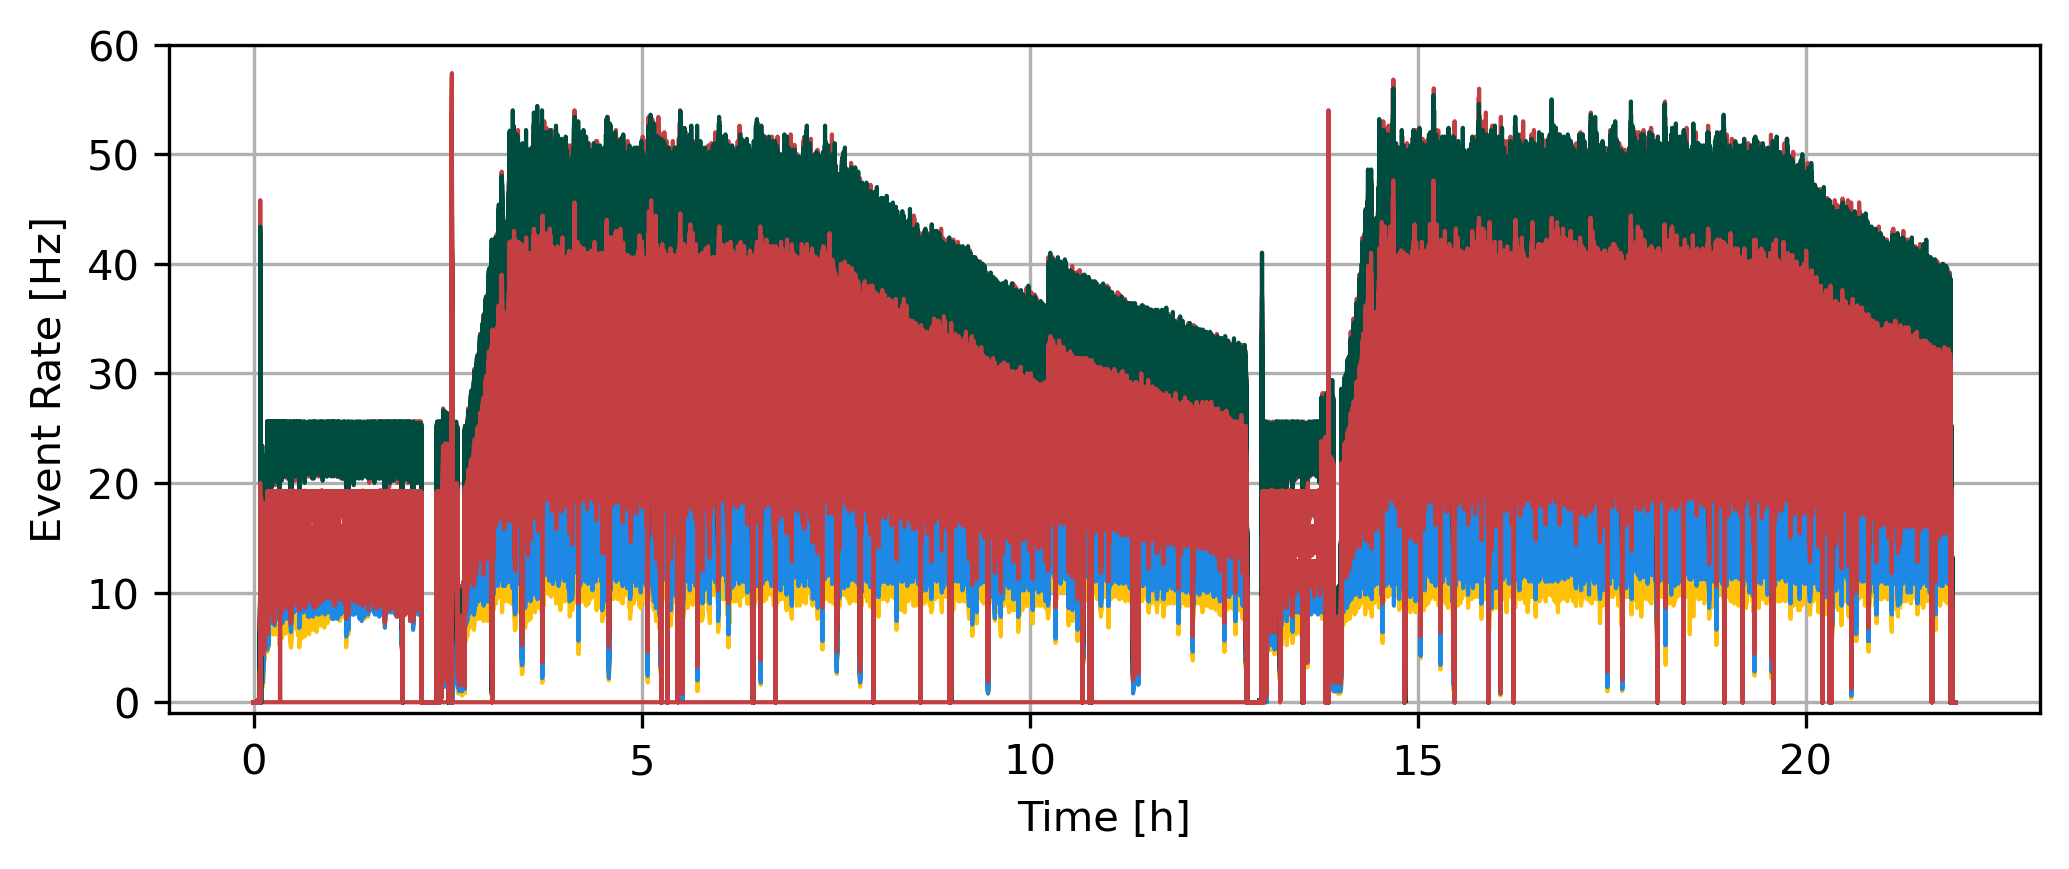

In [14]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)

ax.set_xlabel('Time [h]')
ax.set_ylabel('Event Rate [Hz]')

ax.set_ylim(-1, 60)

ax.grid()

x = np.arange(len(dataset_np[xlim_lower:xlim_upper, :]))*5/3600

for channel in trange(dataset_np.shape[-1], desc='Plotting'):
    ax.plot(x, dataset_np[xlim_lower:xlim_upper, channel], linewidth=1, color=channel_colors[channel])

plt.tight_layout()
plt.show()

# Starting the model prediction

In [ ]:
#!/usr/bin/env python3

import importlib
import argparse
import sys
import datetime as dt
import json
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.logging import logging_redirect_tqdm

#sys.path.append('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/detection_combined/')
sys.path.append('/lcrc/group/ATLAS/users/jj/DiHydra/detection_combined')

from reduction.medianstdreducer import MedianStdReducer
from transformer_based_detection.informers.informerrunner import InformerRunner
from utils.anomalyregstry import JSONAnomalyRegistry
from utils.reduceddatabuffer import ReducedDataBuffer
from utils.exceptions import NonCriticalPredictionException
from utils.consolesingleton import ConsoleSingleton

import clustering.dbscananomalydetector

importlib.reload(clustering.dbscananomalydetector)
from clustering.dbscananomalydetector import HLTDBSCANAnomalyDetector

In [ ]:
hlt_data_pd = pd.read_csv('data/hlt_data_pd_2.csv', index_col=0, parse_dates=True)

rack_config = '2023'

tpu_labels = list(hlt_data_pd.columns.values)

In [ ]:
tpu_labels

In [ ]:
hlt24_cols = [col for col in hlt_data_pd.columns if 'HLT-24' in col]
hlt28_cols = [col for col in hlt_data_pd.columns if 'HLT-28' in col]
hlt32_cols = [col for col in hlt_data_pd.columns if 'HLT-32:' in col]
hlt3232_cols = [col for col in hlt_data_pd.columns if 'HLT-32_32' in col] # 0% overallocation
hlt3240_cols = [col for col in hlt_data_pd.columns if 'HLT-32_40' in col] # 25% overallocation
hlt3248_cols = [col for col in hlt_data_pd.columns if 'HLT-32_48' in col] # 50% overallocation

In [ ]:
m_dbscan_eps = 3
m_dbscan_min_samples = 4
m_dbscan_duration_threshold = 4

dbscan_anomaly_detector = HLTDBSCANAnomalyDetector(tpu_labels,
                                                   m_dbscan_eps,
                                                   m_dbscan_min_samples,
                                                   m_dbscan_duration_threshold)

In [ ]:
output_dir = "output"
json_anomaly_registry = JSONAnomalyRegistry(output_dir)

dbscan_anomaly_detector.register_detection_callback(
                        json_anomaly_registry.clustering_detection)
timestamps = list(hlt_data_pd.index)
hlt_data_np = hlt_data_pd.to_numpy()

In [ ]:
with logging_redirect_tqdm():
    for count, (timestamp, data) in enumerate(tzip(timestamps, hlt_data_np)):
        try:
            dbscan_anomaly_detector.process(timestamp, data)            
        except NonCriticalPredictionException:
            break

json_anomaly_registry.write_log_file("run_456522")

# Testing only on rack-48 as this was the one showing the anomalies
Spoiler. It was a bug, there are no anomalies there...

In [ ]:
def filter_columns(column_name):
    # Split the column name on "."
    parts = column_name.split('.')
    if "rack-48" in parts[0]:
        return True
    return False

dataset_df = pd.read_csv('data/hlt_data_pd_2.csv', index_col=0, parse_dates=True)

# Apply the filter to get the columns we want
filtered_columns = [col for col in dataset_df.columns[:] if filter_columns(col)]

filtered_df = dataset_df[filtered_columns]

#print(filtered_df.shape)
#print(filtered_df.columns)
#print(filtered_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data')
ax.set_ylim(-1, 30)
ax.grid()

# Plot each column
for column in filtered_df.columns:
    label = extract_label(column)
    ax.plot(filtered_df.index, filtered_df[column], label=label)

ax.xaxis_date()
fig.autofmt_xdate()

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import sys

# Load JSON anomaly data
with open('output/run_456522_old.json', 'r') as file: # This was the output file when there was a bug in the tpu_labels due to the overallocation % in 2023
    anomaly_data = json.load(file)

    
# Ensure the DataFrame index is timezone-aware
dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')


# Function to extract intervals for machine "48002"
def extract_intervals_for_machine(anomaly_data, machine_name):
    intervals = []
    if machine_name in anomaly_data:
        for timestamp_str, details in anomaly_data[machine_name].items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration']
            end_time = start_time + timedelta(seconds=duration)
            intervals.append((start_time, end_time))
    return intervals



# Extract intervals for machine "48002"
intervals = extract_intervals_for_machine(anomaly_data, "48002")

# Plotting the time series data
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data')
ax.set_ylim(-1, 30)
ax.grid()




# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]


# Plot each column
for column in filtered_df.columns:
    if "48002" not in column: continue
    label = extract_label(column)
    ax.plot(filtered_df.index, filtered_df[column], label=label)

ax.xaxis_date()
fig.autofmt_xdate()

# Overlay unique anomalies
for start, end in intervals:
    ax.axvspan(start, end, color='red', alpha=0.5, zorder=1)

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

# Now the proper version

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

with open('output/run_454322.json', 'r') as file: 
    anomaly_data = json.load(file)

dataset_df = pd.read_csv('data/hlt_data_pd_454322.csv', index_col=0, parse_dates=True)

In [ ]:
# Ensure the DataFrame index is timezone-aware
dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')  
# Function to extract intervals for all machines
def extract_intervals_for_all_machines(anomaly_data):
    intervals = {}
    for machine_name, anomalies in anomaly_data.items():
        intervals[machine_name] = []
        for timestamp_str, details in anomalies.items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration'] * 5  # Convert timesteps to seconds (each timestep is 5 seconds)
            end_time = start_time + timedelta(seconds=duration)
            anomaly_type = details['types'][0]
            intervals[machine_name].append((start_time, end_time, anomaly_type))
    return intervals


# Extract intervals for all machines
intervals = extract_intervals_for_all_machines(anomaly_data)

# Plotting the time series data for all machines with anomalies
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data')
ax.set_ylim(-1, 30)
ax.grid()

# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

# Initialize legend entries to keep track of added anomaly types
legend_entries = set()

# Plot each column for each machine with anomalies
for machine_id, machine_intervals in intervals.items():
    machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
    for column in machine_columns:
        label = extract_label(column)
        ax.plot(dataset_df.index, dataset_df[column], label=f'Node {label}')
        
    # Overlay unique anomalies using axvspan
    for start, end, anomaly_type in machine_intervals:
        color = 'red' if anomaly_type == 'ClusteringDropToZero' else 'blue'
        if anomaly_type not in legend_entries:
            ax.axvspan(start, end, color=color, alpha=0.5, zorder=1, label=anomaly_type)
            legend_entries.add(anomaly_type)
        else:
            ax.axvspan(start, end, color=color, alpha=0.5, zorder=1)
            
        # Add text annotation for machine_id
        ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)

        

# Improve the formatting of the x-axis for dates
ax.xaxis_date()
fig.autofmt_xdate()

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

plt.tight_layout()
plt.show()


# Getting the plots for all the runs with anomalies

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import random
import os
from matplotlib.backends.backend_pdf import PdfPages

# Function to extract intervals for all machines
def extract_intervals_for_all_machines(anomaly_data):
    intervals = {}
    for machine_name, anomalies in anomaly_data.items():
        machine_name = machine_name.zfill(5)  # Ensure machine ID has 5 digits
        intervals[machine_name] = []
        for timestamp_str, details in anomalies.items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration'] * 5  # Convert timesteps to seconds (each timestep is 5 seconds)
            end_time = start_time + timedelta(seconds=duration)
            anomaly_type = details['types'][0]
            intervals[machine_name].append((start_time, end_time, anomaly_type))
    return intervals

# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

# Define a color palette for different machines
colors = list(mcolors.TABLEAU_COLORS.values())

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.
    
    Parameters:
    color (str or tuple): Matplotlib color
    amount (float): Amount to lighten the color (0 to 1)
    
    Returns:
    tuple: Lightened color
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    white = np.array([1, 1, 1, 1])
    return tuple((1 - amount) * np.array(c) + amount * white)

def plot_run(run_number, pdf=None):
    # Load JSON anomaly data
    json_file = f'output/run_{run_number}.json'
    csv_file = f'data/hlt_data_pd_{run_number}.csv'

    if not os.path.exists(json_file) or not os.path.exists(csv_file):
        print(f"Missing files for run number {run_number}")
        return

    with open(json_file, 'r') as file: 
        anomaly_data = json.load(file)


    dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    # Ensure the DataFrame index is timezone-aware
    dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
    
    # Extract intervals for all machines
    intervals = extract_intervals_for_all_machines(anomaly_data)

    # Plotting the time series data for all machines with anomalies
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    ax.set_xlabel('Time')
    ax.set_ylabel('DCM rate [kHz]')
    ax.set_title(f'Time Series Data for Run {run_number}')
    ax.set_ylim(-1, 60)
    ax.grid()

    legend_entries = set()

    # Plot each column for each machine with anomalies and an extra machine
    for idx, (machine_id, machine_intervals) in enumerate(intervals.items()):
        color = colors[idx % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        # Plot the actual machine with anomalies
        for column in machine_columns:
            label = extract_label(column)
            ax.plot(dataset_df.index, dataset_df[column], label=f'Node - {label}', color=color)
        
        # Find an extra machine with the same starting number but not in the JSON file   
        machine_prefix = str(machine_id)[:2]
        possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
        if possible_extra_machines:
            extra_column = random.choice(possible_extra_machines)
            label = extract_label(extra_column)
            ax.plot(dataset_df.index, dataset_df[extra_column], label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

        # Overlay unique anomalies
        for start, end, anomaly_type in machine_intervals:
            anomaly_color = 'red' if anomaly_type == 'ClusteringDropToZero' else 'blue'
            if anomaly_type not in legend_entries:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1, label=anomaly_type)
                legend_entries.add(anomaly_type)
            else:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1)
                
            # Add text annotation for machine_id
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)


    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    fig.autofmt_xdate()

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

    plt.tight_layout()
    
    if pdf:
        pdf.savefig(fig)
        plt.close(fig)
    else:
        plt.show()

def plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf=None):
    # Define the zoom window duration (e.g., 5 minutes before and after the anomaly)
    zoom_window = timedelta(minutes=5)
    
    for machine_id, machine_intervals in intervals.items():
        color = colors[hash(machine_id) % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        for start, end, anomaly_type in machine_intervals:
            fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
            ax.set_xlabel('Time')
            ax.set_ylabel('DCM rate [kHz]')
            ax.set_title(f'Zoomed Anomaly for Run {run_number} - Node {machine_id}')
            ax.set_ylim(-1, 60)
            ax.grid()
            
            zoom_start = start - zoom_window
            zoom_end = end + zoom_window
            
            # Plot the machine's data within the zoom window
            for column in machine_columns:
                label = extract_label(column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node - {label}', color=color)
            
            # Find an extra machine with the same starting number but not in the JSON file
            machine_prefix = str(machine_id)[:2]
            possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
            if possible_extra_machines:
                extra_column = random.choice(possible_extra_machines)
                label = extract_label(extra_column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, extra_column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

            # Overlay the anomaly interval
            ax.axvspan(start, end, color='red' if anomaly_type == 'ClusteringDropToZero' else 'blue', alpha=0.5, zorder=1, label=anomaly_type)
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)
            

            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
            fig.autofmt_xdate()

            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

            plt.tight_layout()

            if pdf:
                pdf.savefig(fig)
                plt.close(fig)
            else:
                plt.show()



In [ ]:
run_numbers = ['454322', '455795', '455818', '456151', '456164', '456225', '456273', '456314', '455623']

# for run_number in run_numbers:
#     plot_run(run_number)
#     # Load anomaly data and dataset_df as before
#     json_file = f'output/run_{run_number}.json'
#     csv_file = f'data/hlt_data_pd_{run_number}.csv'
#     if os.path.exists(json_file) and os.path.exists(csv_file):
#         with open(json_file, 'r') as file: 
#             anomaly_data = json.load(file)
#         dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
#         dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
#         intervals = extract_intervals_for_all_machines(anomaly_data)
#         plot_zoomed_anomalies(dataset_df, intervals, run_number)
        
        
        
# Create a PDF file to save all plots
with PdfPages('anomaly_plots.pdf') as pdf:
    for run_number in run_numbers:
        plot_run(run_number, pdf)
        # Load anomaly data and dataset_df as before
        json_file = f'output/run_{run_number}.json'
        csv_file = f'data/hlt_data_pd_{run_number}.csv'
        if os.path.exists(json_file) and os.path.exists(csv_file):
            with open(json_file, 'r') as file: 
                anomaly_data = json.load(file)
            dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')
            intervals = extract_intervals_for_all_machines(anomaly_data)
            plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf)


In [ ]:
run_numbers = ['456314']

for run_number in run_numbers:
    plot_run(run_number)
    # Load anomaly data and dataset_df as before
    json_file = f'output/run_{run_number}.json'
    csv_file = f'data/hlt_data_pd_{run_number}.csv'
    if os.path.exists(json_file) and os.path.exists(csv_file):
        with open(json_file, 'r') as file: 
            anomaly_data = json.load(file)
        dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
        dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')
        intervals = extract_intervals_for_all_machines(anomaly_data)
        plot_zoomed_anomalies(dataset_df, intervals, run_number)

# Looking at the informer part

In [ ]:
#!/usr/bin/env python3

import importlib
import argparse
import sys
import datetime as dt
import json
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.logging import logging_redirect_tqdm

sys.path.append('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/detection_combined/')

from utils.anomalyregistry import JSONAnomalyRegistry
from utils.reduceddatabuffer import ReducedDataBuffer
from utils.exceptions import NonCriticalPredictionException
from utils.consolesingleton import ConsoleSingleton

import clustering.dbscananomalydetector
importlib.reload(clustering.dbscananomalydetector)
from clustering.dbscananomalydetector import HLTDBSCANAnomalyDetector

import reduction.medianstdreducer
importlib.reload(reduction.medianstdreducer)
from reduction.medianstdreducer import MedianStdReducer


import transformer_based_detection.informers.informerrunner
importlib.reload(transformer_based_detection.informers.informerrunner)
from transformer_based_detection.informers.informerrunner import InformerRunner

In [ ]:
hlt_data_pd = pd.read_csv('data/hlt_data_pd_456522.csv', index_col=0, parse_dates=True)
#run_numbers = ['454322', '455795', '455818', '456151', '456164', '456225', '456273', '456314', '455623']
# Ensure the DataFrame index is timezone-aware
hlt_data_pd.index = hlt_data_pd.index.tz_convert('Europe/Berlin') 

rack_config = '2023'

median_std_reducer = MedianStdReducer(rack_config)
     
informer_runner = InformerRunner('/eos/user/k/kstehle/Documents/phd/deephydra_models/hlt_2023_mse_Scale_0.8_1.0_Scale_APP_0.8_1.0_0.01_0.05_0.05_rel_size_1.0_ratio_0.25_seed_192/', device='cpu')

tpu_labels = list(hlt_data_pd.columns.values)

In [ ]:
output_dir = "output"
model = "Informer-MSE"

if model == 'Informer-SMSE':
    reduced_data_buffer = ReducedDataBuffer(size=65)
else:
    reduced_data_buffer = ReducedDataBuffer(size=17)


reduced_data_buffer.set_buffer_filled_callback(informer_runner.detect)
        
json_anomaly_registry = JSONAnomalyRegistry(output_dir)

informer_runner.register_detection_callback(
                        json_anomaly_registry.transformer_detection)

timestamps = list(hlt_data_pd.index)
hlt_data_np = hlt_data_pd.to_numpy()

In [ ]:
with logging_redirect_tqdm():
    for count, (timestamp, data) in enumerate(tzip(timestamps, hlt_data_np)):
        try:
            output_slice = median_std_reducer.reduce_numpy(tpu_labels,
                                                            timestamp,
                                                            data)
            reduced_data_buffer.push(output_slice)
        except NonCriticalPredictionException:
            break

json_anomaly_registry.write_log_file("run_456522")